In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM as osvm
from tqdm import tqdm
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold
import time

In [2]:
# The path to features extracted from Kwon rumours and non-rumours has to be placed here 
kRumour = pd.DataFrame.from_csv("")
kNonRumour = pd.DataFrame.from_csv("")

D:\Users\aebrahimifard\AppData\Local\Continuum\anaconda3\envs\myenv01\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.
D:\Users\aebrahimifard\AppData\Local\Continuum\anaconda3\envs\myenv01\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


In [3]:
linguisticFeatures = ["exclamationMarkCount","questionMarkCount","characterCount","tokenCount","subjectivity",\
                      "polarity","uppercaseCount","lowerCaseCount","firstPersonPronounCount","secondPersonPronounCount",\
                      "thirdPersonPronounCount","capitalWordsCount","averageWordComplexity","vuglarTermsCount",\
                      "emoticonCount","abbreviationCount","emojiCount","posAdjectiveCount","posAdpositionCount",\
                      "posAdverbCount","posAuxiliaryCount","posConjunctionCount", "posCoordinatingConjunctionCount" ,"posDeterminerCount",\
                      "posInterjectionCount","posNounCount","posNumeralCount","posParticleCount","posPronounCount",\
                      "posProperNounCount","posPunctuationCount","posSubordinatingConjunctionCount","posSymbolCount",\
                      "posVerbCount","posOtherCount","posSpaceCount","nerPersonCount","nerNationalityCount",\
                      "nerBuildingCount","nerOrganizationCount","nerCountriesCount","nerLocationCount","nerProductCount",\
                      "nerEventCount","nerArtCount","nerLawCount","nerLanguageCount","nerDateCount","nerTimeCount",\
                      "nerMoneyCount","nerQuantityCount","nerOrdinalCount","nerCardinalCount","insight","tentative",\
                      "positiveEmotion","negativeEmotion","anxiety","certainty","tone","sentenceComplexity", "credibilityScore", "engagementScore"]
userFeatures = ["hasProfileDescription","isVerifiedAccount","statusCount","followingCount",\
                "influnece","userRole","totalProfileLikesCount","accountAge","protectedProfile",\
                "hasProfileLocation","hasProfilePicture","averageFollowSpeed",\
                "averageBeingFollowedSpeed","averageLikeSpeed","averageStatusSpeed","screenNameLength",\
                "screenNameDigitCount"]
metaFeatures = ["hashtagCount","mentionCount","hasUrl","tweetPostTime","geoEnabled","multimediaCounter"]

In [11]:
len(linguisticFeatures+userFeatures+metaFeatures)

86

In [4]:
#Separating rumour features by the feature class
kR_ling = kRumour[linguisticFeatures]
kR_user = kRumour[userFeatures]
kR_meta = kRumour[metaFeatures]

In [5]:
#Separating non-rumour features by the feature class
kNR_ling = kNonRumour[linguisticFeatures]
kNR_user = kNonRumour[userFeatures]
kNR_meta = kNonRumour[metaFeatures]

In [6]:
#Setting-Up the experiment for kwon dataset [These conditions wil not differe between different feature sets]
_NuRange = np.arange(0.00000001,1,0.1)
_NuRange = np.append(_NuRange,1)
_GammaRange = np.arange(0.00000001,2,0.5)
_kernel="rbf"
_folds=10
kfold = KFold(n_splits=_folds)

In [7]:
#Doing the experiment for all features
kTime = np.zeros((len(_NuRange),len(_GammaRange)))
kNU = np.zeros((len(_NuRange),len(_GammaRange)))
kGA = np.zeros((len(_NuRange),len(_GammaRange)))
kTP = np.zeros((len(_NuRange),len(_GammaRange)))
kTN = np.zeros((len(_NuRange),len(_GammaRange)))
kFP = np.zeros((len(_NuRange),len(_GammaRange)))
kFN = np.zeros((len(_NuRange),len(_GammaRange)))
kPR = np.zeros((len(_NuRange),len(_GammaRange)))
kRE = np.zeros((len(_NuRange),len(_GammaRange)))
kF1 = np.zeros((len(_NuRange),len(_GammaRange)))
kAC = np.zeros((len(_NuRange),len(_GammaRange)))

kRumourValues = kRumour.values
kNonRumourValues = kNonRumour.values

folds = list(kfold.split(kNonRumourValues))
train_index, test_index = folds[0][0], folds[0][1]
train_data, test_data = kNonRumourValues[train_index], kNonRumourValues[test_index]

### The version with rolling cross-validation

In [8]:
ind1, ind2 = -1,-1 
for _nu in tqdm(_NuRange):
    ind1 += 1
    for _gamma in _GammaRange:
        print(ind2)
        start = time.time()
        ind2 += 1
        ocsvm_kr = osvm(kernel=_kernel, nu=_nu, gamma=_gamma)
        TP_T, FN_T, FP_T, TN_T, PR_T, RE_T, F_T, AC_T  = 0, 0, 0, 0, 0, 0, 0, 0
        for train_index, test_index in kfold.split(kRumourValues):
            
            train_data, test_data = kRumourValues[train_index], kRumourValues[test_index]

            ocsvm_kr_fit = ocsvm_kr.fit(train_data)
            kNonRumourPredict = ocsvm_kr.predict(kNonRumourValues)
            kRumourPredict = ocsvm_kr.predict(test_data)
           
            FP = sum(kNonRumourPredict==1)
            TN = sum(kNonRumourPredict==-1)
            TP = sum(kRumourPredict==1)
            FN = sum(kRumourPredict==-1)
                        
            TP_T += TP
            FN_T += FN
            FP_T += FP
            TN_T += TN
        
        
        TP_T = TP_T / _folds
        FN_T = FN_T / _folds
        FP_T = FP_T / _folds
        TN_T = TN_T / _folds
        PR_T = TP_T/(TP_T+FP_T)
        RE_T = TP_T/(TP_T+FN_T)
        F1_Score = (2*PR_T*RE_T)/(PR_T+RE_T)
        AC_T = (TP_T+TN_T)/(TP_T+FP_T+TN_T+FN_T)
        
        end = time.time()
        executionTime = (end - start)/_folds
        
        kTime[ind1][ind2] = executionTime
        kNU[ind1][ind2] = _nu
        kGA[ind1][ind2] = _gamma
        kF1[ind1][ind2] = F1_Score
        kAC[ind1][ind2] = AC_T
        kPR[ind1][ind2] = PR_T
        kRE[ind1][ind2] = RE_T
        kTP[ind1][ind2] = TP_T
        kTN[ind1][ind2] = TN_T
        kFP[ind1][ind2] = FP_T
        kFN[ind1][ind2] = FN_T
        
    ind2 = -1
    
ocsvm_interval_10fold_k = pd.DataFrame(kTime)
ocsvm_pr1_10fold_k = pd.DataFrame(kNU)
ocsvm_pr2_10fold_k = pd.DataFrame(kGA)
ocsvm_f1_10fold_k = pd.DataFrame(kF1)
ocsvm_ac_10fold_k = pd.DataFrame(kAC)
ocsvm_pr_10fold_k = pd.DataFrame(kPR)
ocsvm_re_10fold_k = pd.DataFrame(kRE)
ocsvm_tp_10fold_k = pd.DataFrame(kTP)
ocsvm_tn_10fold_k = pd.DataFrame(kTN)
ocsvm_fp_10fold_k = pd.DataFrame(kFP)
ocsvm_fn_10fold_k = pd.DataFrame(kFN) 

ocsvm_interval_10fold_k.to_csv("ocsvm_interval_10fold_k.csv")
ocsvm_pr1_10fold_k.to_csv("ocsvm_pr1_10fold_k.csv")
ocsvm_pr2_10fold_k.to_csv("ocsvm_pr2_10fold_k.csv")
ocsvm_f1_10fold_k.to_csv("ocsvm_f1_10fold_k.csv")
ocsvm_ac_10fold_k.to_csv("ocsvm_ac_10fold_k.csv")
ocsvm_pr_10fold_k.to_csv("ocsvm_pr_10fold_k.csv")
ocsvm_re_10fold_k.to_csv("ocsvm_re_10fold_k.csv")
ocsvm_tp_10fold_k.to_csv("ocsvm_tp_10fold_k.csv")
ocsvm_tn_10fold_k.to_csv("ocsvm_tn_10fold_k.csv")
ocsvm_fp_10fold_k.to_csv("ocsvm_fp_10fold_k.csv")
ocsvm_fn_10fold_k.to_csv("ocsvm_fn_10fold_k.csv")

  0%|                                                   | 0/11 [00:00<?, ?it/s]

-1


D:\Users\aebrahimifard\AppData\Local\Continuum\anaconda3\envs\myenv01\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


0


D:\Users\aebrahimifard\AppData\Local\Continuum\anaconda3\envs\myenv01\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


1


D:\Users\aebrahimifard\AppData\Local\Continuum\anaconda3\envs\myenv01\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


2


D:\Users\aebrahimifard\AppData\Local\Continuum\anaconda3\envs\myenv01\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
  9%|███▉                                       | 1/11 [00:23<03:52, 23.26s/it]

-1
0
1
2


 18%|██████▋                              | 2/11 [1:03:31<2:52:54, 1152.76s/it]

-1
0
1
2


 27%|██████████                           | 3/11 [2:56:03<6:17:41, 2832.64s/it]

-1
0
1
2


 36%|█████████████                       | 4/11 [9:01:35<16:38:56, 8562.29s/it]

-1
0
1
2


 45%|███████████████▉                   | 5/11 [12:34:40<16:22:54, 9829.05s/it]

-1
0
1
2


 55%|██████████████████▌               | 6/11 [16:55:07<16:04:02, 11568.47s/it]

-1
0
1
2


 64%|█████████████████████▋            | 7/11 [21:52:29<14:56:42, 13450.72s/it]

-1
0
1
2


 73%|████████████████████████▋         | 8/11 [27:16:22<12:42:15, 15245.29s/it]

-1
0
1
2


 82%|████████████████████████████▋      | 9/11 [33:44:18<9:48:29, 17654.61s/it]

-1
0
1
2


 91%|██████████████████████████████▉   | 10/11 [40:43:45<5:31:48, 19908.29s/it]

-1


D:\Users\aebrahimifard\AppData\Local\Continuum\anaconda3\envs\myenv01\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


0


D:\Users\aebrahimifard\AppData\Local\Continuum\anaconda3\envs\myenv01\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


1


D:\Users\aebrahimifard\AppData\Local\Continuum\anaconda3\envs\myenv01\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


2


D:\Users\aebrahimifard\AppData\Local\Continuum\anaconda3\envs\myenv01\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
100%|████████████████████████████████████| 11/11 [47:17:39<00:00, 21026.03s/it]


In [ ]:
#Setting-Up the experiment for kwon dataset [These conditions wil not differe between different feature sets]
_NuRange = np.arange(0.00000001,1,0.1)
_NuRange = np.append(_NuRange,1)
_GammaRange = np.arange(0.00000001,5,0.5)
_kernel="rbf"
_folds=5
kfold = KFold(n_splits=_folds)

In [ ]:
#Doing the experiment for all features
kTime = np.zeros((len(_NuRange),len(_GammaRange)))
kNU = np.zeros((len(_NuRange),len(_GammaRange)))
kGA = np.zeros((len(_NuRange),len(_GammaRange)))
kTP = np.zeros((len(_NuRange),len(_GammaRange)))
kTN = np.zeros((len(_NuRange),len(_GammaRange)))
kFP = np.zeros((len(_NuRange),len(_GammaRange)))
kFN = np.zeros((len(_NuRange),len(_GammaRange)))
kPR = np.zeros((len(_NuRange),len(_GammaRange)))
kRE = np.zeros((len(_NuRange),len(_GammaRange)))
kF1 = np.zeros((len(_NuRange),len(_GammaRange)))
kAC = np.zeros((len(_NuRange),len(_GammaRange)))

kRumourValues = kRumour.values
kNonRumourValues = kNonRumour.values

folds = list(kfold.split(kNonRumourValues))
train_index, test_index = folds[0][0], folds[0][1]
train_data, test_data = kNonRumourValues[train_index], kNonRumourValues[test_index]

In [ ]:
ind1, ind2 = -1,-1 
for _nu in tqdm(_NuRange):
    ind1 += 1
    for _gamma in _GammaRange:
        print(ind2)
        start = time.time()
        ind2 += 1
        ocsvm_kr = osvm(kernel=_kernel, nu=_nu, gamma=_gamma)
        TP_T, FN_T, FP_T, TN_T, PR_T, RE_T, F_T, AC_T  = 0, 0, 0, 0, 0, 0, 0, 0
        for train_index, test_index in kfold.split(kRumourValues):
            
            train_data, test_data = kRumourValues[train_index], kRumourValues[test_index]

            ocsvm_kr_fit = ocsvm_kr.fit(train_data)
            kNonRumourPredict = ocsvm_kr.predict(kNonRumourValues)
            kRumourPredict = ocsvm_kr.predict(test_data)
           
            FP = sum(kNonRumourPredict==1)
            TN = sum(kNonRumourPredict==-1)
            TP = sum(kRumourPredict==1)
            FN = sum(kRumourPredict==-1)
                        
            TP_T += TP
            FN_T += FN
            FP_T += FP
            TN_T += TN
        
        
        TP_T = TP_T / _folds
        FN_T = FN_T / _folds
        FP_T = FP_T / _folds
        TN_T = TN_T / _folds
        PR_T = TP_T/(TP_T+FP_T)
        RE_T = TP_T/(TP_T+FN_T)
        F1_Score = (2*PR_T*RE_T)/(PR_T+RE_T)
        AC_T = (TP_T+TN_T)/(TP_T+FP_T+TN_T+FN_T)
        
        end = time.time()
        executionTime = (end - start)/_folds
        
        kTime[ind1][ind2] = executionTime
        kNU[ind1][ind2] = _nu
        kGA[ind1][ind2] = _gamma
        kF1[ind1][ind2] = F1_Score
        kAC[ind1][ind2] = AC_T
        kPR[ind1][ind2] = PR_T
        kRE[ind1][ind2] = RE_T
        kTP[ind1][ind2] = TP_T
        kTN[ind1][ind2] = TN_T
        kFP[ind1][ind2] = FP_T
        kFN[ind1][ind2] = FN_T
        
    ind2 = -1
    
ocsvm_interval_5fold_k = pd.DataFrame(kTime)
ocsvm_pr1_5fold_k = pd.DataFrame(kNU)
ocsvm_pr2_5fold_k = pd.DataFrame(kGA)
ocsvm_f1_5fold_k = pd.DataFrame(kF1)
ocsvm_ac_5fold_k = pd.DataFrame(kAC)
ocsvm_pr_5fold_k = pd.DataFrame(kPR)
ocsvm_re_5fold_k = pd.DataFrame(kRE)
ocsvm_tp_5fold_k = pd.DataFrame(kTP)
ocsvm_tn_5fold_k = pd.DataFrame(kTN)
ocsvm_fp_5fold_k = pd.DataFrame(kFP)
ocsvm_fn_5fold_k = pd.DataFrame(kFN) 

ocsvm_interval_5fold_k.to_csv("ocsvm_interval_5fold_k.csv")
ocsvm_pr1_5fold_k.to_csv("ocsvm_pr1_5fold_k.csv")
ocsvm_pr2_5fold_k.to_csv("ocsvm_pr2_5fold_k.csv")
ocsvm_f1_5fold_k.to_csv("ocsvm_f1_5fold_k.csv")
ocsvm_ac_5fold_k.to_csv("ocsvm_ac_5fold_k.csv")
ocsvm_pr_5fold_k.to_csv("ocsvm_pr_5fold_k.csv")
ocsvm_re_5fold_k.to_csv("ocsvm_re_5fold_k.csv")
ocsvm_tp_5fold_k.to_csv("ocsvm_tp_5fold_k.csv")
ocsvm_tn_5fold_k.to_csv("ocsvm_tn_5fold_k.csv")
ocsvm_fp_5fold_k.to_csv("ocsvm_fp_5fold_k.csv")
ocsvm_fn_5fold_k.to_csv("ocsvm_fn_5fold_k.csv")

In [ ]:
#Setting-Up the experiment for kwon dataset [These conditions wil not differe between different feature sets]
_NuRange = np.arange(0.00000001,1,0.1)
_NuRange = np.append(_NuRange,1)
_GammaRange = np.arange(0.00000001,5,0.5)
_kernel="rbf"
_folds=3
kfold = KFold(n_splits=_folds)

In [ ]:
#Doing the experiment for all features
kTime = np.zeros((len(_NuRange),len(_GammaRange)))
kNU = np.zeros((len(_NuRange),len(_GammaRange)))
kGA = np.zeros((len(_NuRange),len(_GammaRange)))
kTP = np.zeros((len(_NuRange),len(_GammaRange)))
kTN = np.zeros((len(_NuRange),len(_GammaRange)))
kFP = np.zeros((len(_NuRange),len(_GammaRange)))
kFN = np.zeros((len(_NuRange),len(_GammaRange)))
kPR = np.zeros((len(_NuRange),len(_GammaRange)))
kRE = np.zeros((len(_NuRange),len(_GammaRange)))
kF1 = np.zeros((len(_NuRange),len(_GammaRange)))
kAC = np.zeros((len(_NuRange),len(_GammaRange)))

kRumourValues = kRumour.values
kNonRumourValues = kNonRumour.values

folds = list(kfold.split(kNonRumourValues))
train_index, test_index = folds[0][0], folds[0][1]
train_data, test_data = kNonRumourValues[train_index], kNonRumourValues[test_index]

In [ ]:
ind1, ind2 = -1,-1 
for _nu in tqdm(_NuRange):
    ind1 += 1
    for _gamma in _GammaRange:
        print(ind2)
        start = time.time()
        ind2 += 1
        ocsvm_kr = osvm(kernel=_kernel, nu=_nu, gamma=_gamma)
        TP_T, FN_T, FP_T, TN_T, PR_T, RE_T, F_T, AC_T  = 0, 0, 0, 0, 0, 0, 0, 0
        for train_index, test_index in kfold.split(kRumourValues):
            
            train_data, test_data = kRumourValues[train_index], kRumourValues[test_index]

            ocsvm_kr_fit = ocsvm_kr.fit(train_data)
            kNonRumourPredict = ocsvm_kr.predict(kNonRumourValues)
            kRumourPredict = ocsvm_kr.predict(test_data)
           
            FP = sum(kNonRumourPredict==1)
            TN = sum(kNonRumourPredict==-1)
            TP = sum(kRumourPredict==1)
            FN = sum(kRumourPredict==-1)

                        
            TP_T += TP
            FN_T += FN
            FP_T += FP
            TN_T += TN
        
        
        TP_T = TP_T / _folds
        FN_T = FN_T / _folds
        FP_T = FP_T / _folds
        TN_T = TN_T / _folds
        PR_T = TP_T/(TP_T+FP_T)
        RE_T = TP_T/(TP_T+FN_T)
        F1_Score = (2*PR_T*RE_T)/(PR_T+RE_T)
        AC_T = (TP_T+TN_T)/(TP_T+FP_T+TN_T+FN_T)
        
        end = time.time()
        executionTime = (end - start)/_folds
        
        kTime[ind1][ind2] = executionTime
        kNU[ind1][ind2] = _nu
        kGA[ind1][ind2] = _gamma
        kF1[ind1][ind2] = F1_Score
        kAC[ind1][ind2] = AC_T
        kPR[ind1][ind2] = PR_T
        kRE[ind1][ind2] = RE_T
        kTP[ind1][ind2] = TP_T
        kTN[ind1][ind2] = TN_T
        kFP[ind1][ind2] = FP_T
        kFN[ind1][ind2] = FN_T
        
    ind2 = -1
    
ocsvm_interval_3fold_k = pd.DataFrame(kTime)
ocsvm_pr1_3fold_k = pd.DataFrame(kNU)
ocsvm_pr2_3fold_k = pd.DataFrame(kGA)
ocsvm_f1_3fold_k = pd.DataFrame(kF1)
ocsvm_ac_3fold_k = pd.DataFrame(kAC)
ocsvm_pr_3fold_k = pd.DataFrame(kPR)
ocsvm_re_3fold_k = pd.DataFrame(kRE)
ocsvm_tp_3fold_k = pd.DataFrame(kTP)
ocsvm_tn_3fold_k = pd.DataFrame(kTN)
ocsvm_fp_3fold_k = pd.DataFrame(kFP)
ocsvm_fn_3fold_k = pd.DataFrame(kFN) 

ocsvm_interval_3fold_k.to_csv("ocsvm_interval_3fold_k.csv")
ocsvm_pr1_3fold_k.to_csv("ocsvm_pr1_3fold_k.csv")
ocsvm_pr2_3fold_k.to_csv("ocsvm_pr2_3fold_k.csv")
ocsvm_f1_3fold_k.to_csv("ocsvm_f1_3fold_k.csv")
ocsvm_ac_3fold_k.to_csv("ocsvm_ac_3fold_k.csv")
ocsvm_pr_3fold_k.to_csv("ocsvm_pr_3fold_k.csv")
ocsvm_re_3fold_k.to_csv("ocsvm_re_3fold_k.csv")
ocsvm_tp_3fold_k.to_csv("ocsvm_tp_3fold_k.csv")
ocsvm_tn_3fold_k.to_csv("ocsvm_tn_3fold_k.csv")
ocsvm_fp_3fold_k.to_csv("ocsvm_fp_3fold_k.csv")
ocsvm_fn_3fold_k.to_csv("ocsvm_fn_3fold_k.csv")

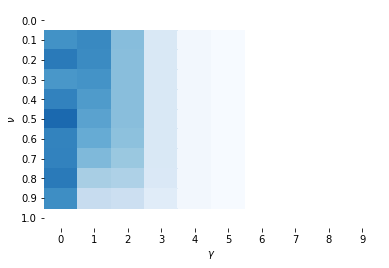

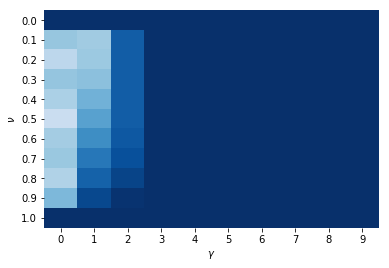

In [12]:
#Preparing dataframes for seaborn heatmap 
#We are going to visualize the performance of one-class classifier on Zubiaga dataset according to nu and gamma (kernel parameter)
df_z_F1 = pd.DataFrame(columns=[i for i in _GammaRange])
df_z_ACC = pd.DataFrame(columns=[i for i in _GammaRange])
df_z_PR = pd.DataFrame(columns=[i for i in _GammaRange])
df_z_RE = pd.DataFrame(columns=[i for i in _GammaRange])
df_z_TP = pd.DataFrame(columns=[i for i in _GammaRange])
df_z_TN = pd.DataFrame(columns=[i for i in _GammaRange])
df_z_FP = pd.DataFrame(columns=[i for i in _GammaRange])
df_z_FN = pd.DataFrame(columns=[i for i in _GammaRange])
df_z_TPR = pd.DataFrame(columns=[i for i in _GammaRange])
df_z_FPR = pd.DataFrame(columns=[i for i in _GammaRange])


for i in _NuRange:
    df_z_F1.loc[i] = [zF1[i][j] for j in _GammaRange]
    df_z_ACC.loc[i] = [zACC[i][j] for j in _GammaRange]
    df_z_PR.loc[i] = [zPR[i][j] for j in _GammaRange]
    df_z_RE.loc[i] = [zRE[i][j] for j in _GammaRange]
    df_z_TP.loc[i] = [zTP[i][j] for j in _GammaRange]
    df_z_TN.loc[i] = [zTN[i][j] for j in _GammaRange]
    df_z_FP.loc[i] = [zFP[i][j] for j in _GammaRange]
    df_z_FN.loc[i] = [zFN[i][j] for j in _GammaRange]
    df_z_TPR.loc[i] = [zTPR[i][j] for j in _GammaRange]
    df_z_FPR.loc[i] = [zFPR[i][j] for j in _GammaRange]


df_z_F1.index = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
df_z_ACC.index = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
df_z_F1.columns = [0,1,2,3,4,5,6,7,8,9]
df_z_ACC.columns = [0,1,2,3,4,5,6,7,8,9]

ax = sns.heatmap(df_z_F1, cmap="Blues", vmin=0, vmax=0.35, cbar=False)
plt.yticks(rotation=0)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\nu$')
plt.savefig("df_z_F1.eps")
plt.show()

ax = sns.heatmap(df_z_ACC, cmap="Blues", vmin=0, vmax=0.8, cbar=False)
plt.yticks(rotation=0)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\nu$')
plt.savefig("df_z_ACC.eps")
plt.show()

In [13]:
#Doing the experiment for linguistic features
df_zLPerformance = pd.DataFrame(columns=["kernel", "nu","gamma","PR","RE","F1","AC","TP","FP","TN","FN", "TPR", "FPR"])
zLF1, zLACC, zLPR, zLRE, zLTP, zLTN, zLFP, zLFN, zLTPR, zLFPR = {a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange}, \
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange}

zLRumourValues = zR_ling.values
zLNonRumourValues = zNR_ling.values

In [14]:
for _nu in tqdm(_NuRange):
    for _gamma in _GammaRange:
        ocsvm_zr = osvm(kernel=_kernel, nu=_nu, gamma=_gamma)
        TP_T, FN_T, FP_T, TN_T, PR_T, RE_T, F_T, AC_T, TPR_T, FPR_T  = 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0
        for train_index, test_index in kfold.split(zLRumourValues):
            train_data, test_data = zLRumourValues[train_index], zLRumourValues[test_index]
            
            ocsvm_zr_fit = ocsvm_zr.fit(train_data)
            zNonRumourPredict = ocsvm_zr.predict(zLNonRumourValues)
            zRumourPredict = ocsvm_zr.predict(test_data)
            
            FP = sum(zNonRumourPredict==1)
            TN = sum(zNonRumourPredict==-1)
            TP = sum(zRumourPredict==1)
            FN = sum(zRumourPredict==-1)
                        
            TP_T += TP
            FN_T += FN
            FP_T += FP
            TN_T += TN
            
        TP_T = TP_T / _folds
        FN_T = FN_T / _folds
        FP_T = FP_T / _folds
        TN_T = TN_T / _folds
        PR_T = TP_T/(TP_T+FP_T)
        RE_T = TP_T/(TP_T+FN_T)
        F1_Score = (2*PR_T*RE_T)/(PR_T+RE_T)
        ACC_T = (TP_T+TN_T)/(TP_T+FP_T+TN_T+FN_T)
        TPR_T = TP_T/(TP_T+FN_T)
        FPR_T = FP_T/(FP_T+TN_T)
        
        zLF1[_nu][_gamma] = F1_Score
        zLACC[_nu][_gamma] = ACC_T
        zLPR[_nu][_gamma] = PR_T
        zLRE[_nu][_gamma] = RE_T
        zLTP[_nu][_gamma] = TP_T
        zLTN[_nu][_gamma] = TN_T
        zLFP[_nu][_gamma] = FP_T
        zLFN[_nu][_gamma] = FN_T
        zLTPR[_nu][_gamma] = TPR_T
        zLFPR[_nu][_gamma] = FPR_T
        
        df_zLPerformance.loc[len(df_zLPerformance)]=[_kernel,_nu,_gamma,PR_T,RE_T,F1_Score,ACC_T,TP_T,FP_T,TN_T,FN_T,TPR_T,FPR_T]

100%|██████████████████████████████████████████| 11/11 [03:50<00:00, 20.94s/it]


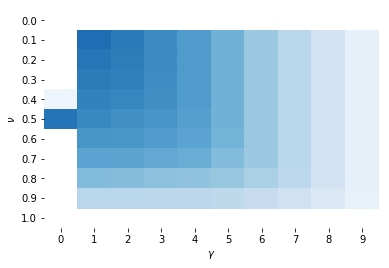

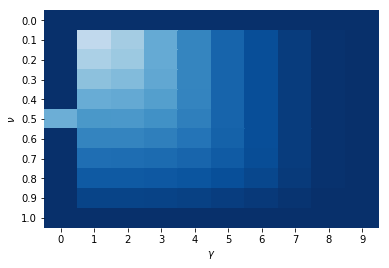

In [15]:
#Preparing dataframes for seaborn heatmap 
#We are going to visualize the performance of one-class classifier on Zubiaga dataset according to nu and gamma (kernel parameter)
df_zL_F1 = pd.DataFrame(columns=[i for i in _GammaRange])
df_zL_ACC = pd.DataFrame(columns=[i for i in _GammaRange])
df_zL_PR = pd.DataFrame(columns=[i for i in _GammaRange])
df_zL_RE = pd.DataFrame(columns=[i for i in _GammaRange])
df_zL_TP = pd.DataFrame(columns=[i for i in _GammaRange])
df_zL_TN = pd.DataFrame(columns=[i for i in _GammaRange])
df_zL_FP = pd.DataFrame(columns=[i for i in _GammaRange])
df_zL_FN = pd.DataFrame(columns=[i for i in _GammaRange])
df_zL_TPR = pd.DataFrame(columns=[i for i in _GammaRange])
df_zL_FPR = pd.DataFrame(columns=[i for i in _GammaRange])

for i in _NuRange:
    df_zL_F1.loc[i] = [zLF1[i][j] for j in _GammaRange]
    df_zL_ACC.loc[i] = [zLACC[i][j] for j in _GammaRange]
    df_zL_PR.loc[i] = [zLPR[i][j] for j in _GammaRange]
    df_zL_RE.loc[i] = [zLRE[i][j] for j in _GammaRange]
    df_zL_TP.loc[i] = [zLTP[i][j] for j in _GammaRange]
    df_zL_TN.loc[i] = [zLTN[i][j] for j in _GammaRange]
    df_zL_FP.loc[i] = [zLFP[i][j] for j in _GammaRange]
    df_zL_FN.loc[i] = [zLFN[i][j] for j in _GammaRange]
    df_zL_TPR.loc[i] = [zLTPR[i][j] for j in _GammaRange]
    df_zL_FPR.loc[i] = [zLFPR[i][j] for j in _GammaRange]

df_zL_F1.index = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
df_zL_ACC.index = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
df_zL_F1.columns = [0,1,2,3,4,5,6,7,8,9]
df_zL_ACC.columns = [0,1,2,3,4,5,6,7,8,9]


ax = sns.heatmap(df_zL_F1, cmap="Blues", vmin=0, vmax=0.35, cbar=False)
plt.yticks(rotation=0)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\nu$')
plt.savefig("df_zL_F1.eps")
plt.show()

ax = sns.heatmap(df_zL_ACC, cmap="Blues", vmin=0, vmax=0.8, cbar=False)
plt.yticks(rotation=0)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\nu$')
plt.savefig("df_zL_ACC.eps")
plt.show()

In [16]:
#Doing the experiment for user features
df_zUPerformance = pd.DataFrame(columns=["kernel", "nu","gamma","PR","RE","F1","AC","TP","FP","TN","FN", "TPR", "FPR"])
zUF1, zUACC, zUPR, zURE, zUTP, zUTN, zUFP, zUFN, zUTPR, zUFPR = {a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange}, \
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange}

zURumourValues = zR_user.values
zUNonRumourValues = zNR_user.values

In [17]:
for _nu in tqdm(_NuRange):
    for _gamma in _GammaRange:
        ocsvm_zr = osvm(kernel=_kernel, nu=_nu, gamma=_gamma)
        TP_T, FN_T, FP_T, TN_T, PR_T, RE_T, F_T, AC_T, TPR_T, FPR_T  = 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0
        for train_index, test_index in kfold.split(zURumourValues):
            train_data, test_data = zURumourValues[train_index], zURumourValues[test_index]
            
            ocsvm_zr_fit = ocsvm_zr.fit(train_data)
            zNonRumourPredict = ocsvm_zr.predict(zUNonRumourValues)
            zRumourPredict = ocsvm_zr.predict(test_data)
            
            FP = sum(zNonRumourPredict==1)
            TN = sum(zNonRumourPredict==-1)
            TP = sum(zRumourPredict==1)
            FN = sum(zRumourPredict==-1)
                        
            TP_T += TP
            FN_T += FN
            FP_T += FP
            TN_T += TN
            
        TP_T = TP_T / _folds
        FN_T = FN_T / _folds
        FP_T = FP_T / _folds
        TN_T = TN_T / _folds
        PR_T = TP_T/(TP_T+FP_T)
        RE_T = TP_T/(TP_T+FN_T)
        F1_Score = (2*PR_T*RE_T)/(PR_T+RE_T)
        ACC_T = (TP_T+TN_T)/(TP_T+FP_T+TN_T+FN_T)
        TPR_T = TP_T/(TP_T+FN_T)
        FPR_T = FP_T/(FP_T+TN_T)
        
        zUF1[_nu][_gamma] = F1_Score
        zUACC[_nu][_gamma] = ACC_T
        zUPR[_nu][_gamma] = PR_T
        zURE[_nu][_gamma] = RE_T
        zUTP[_nu][_gamma] = TP_T
        zUTN[_nu][_gamma] = TN_T
        zUFP[_nu][_gamma] = FP_T
        zUFN[_nu][_gamma] = FN_T
        zUTPR[_nu][_gamma] = TPR_T
        zUFPR[_nu][_gamma] = FPR_T
        
        df_zUPerformance.loc[len(df_zUPerformance)]=[_kernel,_nu,_gamma,PR_T,RE_T,F1_Score,ACC_T,TP_T,FP_T,TN_T,FN_T,TPR_T,FPR_T]

100%|██████████████████████████████████████████| 11/11 [01:14<00:00,  6.82s/it]


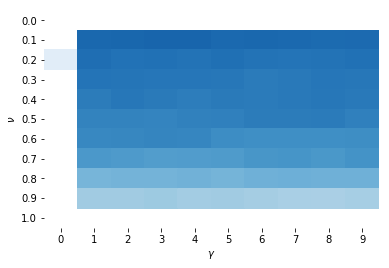

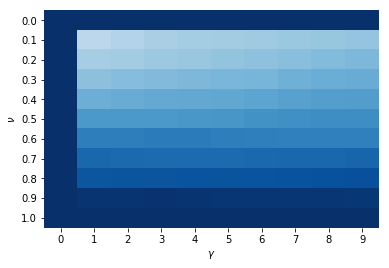

In [18]:
#Preparing dataframes for seaborn heatmap 
#We are going to visualize the performance of one-class classifier on Zubiaga dataset according to nu and gamma (kernel parameter)
df_zU_F1 = pd.DataFrame(columns=[i for i in _GammaRange])
df_zU_ACC = pd.DataFrame(columns=[i for i in _GammaRange])
df_zU_PR = pd.DataFrame(columns=[i for i in _GammaRange])
df_zU_RE = pd.DataFrame(columns=[i for i in _GammaRange])
df_zU_TP = pd.DataFrame(columns=[i for i in _GammaRange])
df_zU_TN = pd.DataFrame(columns=[i for i in _GammaRange])
df_zU_FP = pd.DataFrame(columns=[i for i in _GammaRange])
df_zU_FN = pd.DataFrame(columns=[i for i in _GammaRange])
df_zU_TPR = pd.DataFrame(columns=[i for i in _GammaRange])
df_zU_FPR = pd.DataFrame(columns=[i for i in _GammaRange])


for i in _NuRange:
    df_zU_F1.loc[i] = [zUF1[i][j] for j in _GammaRange]
    df_zU_ACC.loc[i] = [zUACC[i][j] for j in _GammaRange]
    df_zU_PR.loc[i] = [zUPR[i][j] for j in _GammaRange]
    df_zU_RE.loc[i] = [zURE[i][j] for j in _GammaRange]
    df_zU_TP.loc[i] = [zUTP[i][j] for j in _GammaRange]
    df_zU_TN.loc[i] = [zUTN[i][j] for j in _GammaRange]
    df_zU_FP.loc[i] = [zUFP[i][j] for j in _GammaRange]
    df_zU_FN.loc[i] = [zUFN[i][j] for j in _GammaRange]
    df_zU_TPR.loc[i] = [zUTPR[i][j] for j in _GammaRange]
    df_zU_FPR.loc[i] = [zUFPR[i][j] for j in _GammaRange]

df_zU_F1.index = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
df_zU_ACC.index = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
df_zU_F1.columns = [0,1,2,3,4,5,6,7,8,9]
df_zU_ACC.columns = [0,1,2,3,4,5,6,7,8,9]


ax = sns.heatmap(df_zU_F1, cmap="Blues", vmin=0, vmax=0.35, cbar=False)
plt.yticks(rotation=0)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\nu$')
plt.savefig("df_zU_F1.eps")
plt.show()

ax = sns.heatmap(df_zU_ACC, cmap="Blues", vmin=0, vmax=0.8, cbar=False)
plt.yticks(rotation=0)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\nu$')
plt.savefig("df_zU_ACC.eps")
plt.show()

In [19]:
#Doing the experiment for meta features
df_zMPerformance = pd.DataFrame(columns=["kernel", "nu","gamma","PR","RE","F1","AC","TP","FP","TN","FN", "TPR", "FPR"])
zMF1, zMACC, zMPR, zMRE, zMTP, zMTN, zMFP, zMFN, zMTPR, zMFPR = {a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange}, \
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange},\
{a:{b:0 for b in _GammaRange} for a in _NuRange}

zMRumourValues = zR_meta.values
zMNonRumourValues = zNR_meta.values

In [20]:
ind1, ind2 = 0,0 ;
for _nu in tqdm(_NuRange):
    ind1 += 1
    for _gamma in _GammaRange:
        ind2 += 1
        ocsvm_zr = osvm(kernel=_kernel, nu=_nu, gamma=_gamma)
        TP_T, FN_T, FP_T, TN_T, PR_T, RE_T, F_T, AC_T, TPR_T, FPR_T  = 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0
        for train_index, test_index in kfold.split(zMRumourValues):
            train_data, test_data = zMRumourValues[train_index], zMRumourValues[test_index]
            
            ocsvm_zr_fit = ocsvm_zr.fit(train_data)
            zNonRumourPredict = ocsvm_zr.predict(zMNonRumourValues)
            zRumourPredict = ocsvm_zr.predict(test_data)
            
            FP = sum(zNonRumourPredict==1)
            TN = sum(zNonRumourPredict==-1)
            TP = sum(zRumourPredict==1)
            FN = sum(zRumourPredict==-1)
                        
            TP_T += TP
            FN_T += FN
            FP_T += FP
            TN_T += TN
            
        TP_T = TP_T / _folds
        FN_T = FN_T / _folds
        FP_T = FP_T / _folds
        TN_T = TN_T / _folds
        PR_T = TP_T/(TP_T+FP_T)
        RE_T = TP_T/(TP_T+FN_T)
        F1_Score = (2*PR_T*RE_T)/(PR_T+RE_T)
        ACC_T = (TP_T+TN_T)/(TP_T+FP_T+TN_T+FN_T)

        
        zMF1[_nu][_gamma] = F1_Score
        zMACC[_nu][_gamma] = ACC_T
        zMPR[_nu][_gamma] = PR_T
        zMRE[_nu][_gamma] = RE_T
        zMTP[_nu][_gamma] = TP_T
        zMTN[_nu][_gamma] = TN_T
        zMFP[_nu][_gamma] = FP_T
        zMFN[_nu][_gamma] = FN_T
        zMTPR[_nu][_gamma] = TPR_T
        zMFPR[_nu][_gamma] = FPR_T
    ind2 = 0

100%|██████████████████████████████████████████| 11/11 [00:56<00:00,  5.12s/it]


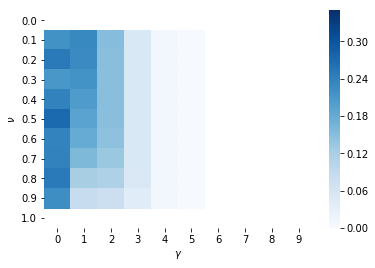

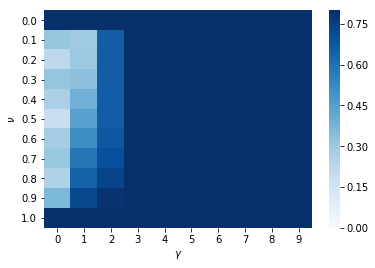

In [21]:
#Preparing dataframes for seaborn heatmap 
#We are going to visualize the performance of one-class classifier on Zubiaga dataset according to nu and gamma (kernel parameter)
df_zM_F1 = pd.DataFrame(columns=[i for i in _GammaRange])
df_zM_ACC = pd.DataFrame(columns=[i for i in _GammaRange])
df_zM_PR = pd.DataFrame(columns=[i for i in _GammaRange])
df_zM_RE = pd.DataFrame(columns=[i for i in _GammaRange])
df_zM_TP = pd.DataFrame(columns=[i for i in _GammaRange])
df_zM_TN = pd.DataFrame(columns=[i for i in _GammaRange])
df_zM_FP = pd.DataFrame(columns=[i for i in _GammaRange])
df_zM_FN = pd.DataFrame(columns=[i for i in _GammaRange])
df_zM_TPR = pd.DataFrame(columns=[i for i in _GammaRange])
df_zM_FPR = pd.DataFrame(columns=[i for i in _GammaRange])


for i in _NuRange:
    df_zM_F1.loc[i] = [zF1[i][j] for j in _GammaRange]
    df_zM_ACC.loc[i] = [zACC[i][j] for j in _GammaRange]
    df_zM_PR.loc[i] = [zPR[i][j] for j in _GammaRange]
    df_zM_RE.loc[i] = [zRE[i][j] for j in _GammaRange]
    df_zM_TP.loc[i] = [zTP[i][j] for j in _GammaRange]
    df_zM_TN.loc[i] = [zTN[i][j] for j in _GammaRange]
    df_zM_FP.loc[i] = [zFP[i][j] for j in _GammaRange]
    df_zM_FN.loc[i] = [zFN[i][j] for j in _GammaRange]
    df_zM_TPR.loc[i] = [zTPR[i][j] for j in _GammaRange]
    df_zM_FPR.loc[i] = [zFPR[i][j] for j in _GammaRange]

df_zM_F1.index = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
df_zM_ACC.index = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
df_zM_F1.columns = [0,1,2,3,4,5,6,7,8,9]
df_zM_ACC.columns = [0,1,2,3,4,5,6,7,8,9]


ax = sns.heatmap(df_zM_F1, cmap="Blues", vmin=0, vmax=0.35)
plt.yticks(rotation=0)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\nu$')
plt.savefig("df_zM_F1.eps")
plt.show()

ax = sns.heatmap(df_zM_ACC, cmap="Blues", vmin=0, vmax=0.8)
plt.yticks(rotation=0)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\nu$')
plt.savefig("df_zM_ACC.eps")
plt.show()